In [ ]:
import pandas as pd
from PIL import Image, ImageDraw
from PIL import ImagePath
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf

Extracting files:

In [ ]:
def return_file_names_df(root_dir):

  data_files = zipfile.ZipFile(root_dir, mode="r")
  filename_list = data_files.namelist()
  data_files.extractall('/content/drive/MyDrive/segmentation_data') # extracting to drive
  data_files.close()

  data_df = pd.DataFrame()
  image_list = []
  mask_list = []
  for file in filename_list:
    if '.jpg' in file:
      image_list.append(file)
    if '.json' in file:
      mask_list.append(file)   

  data_df['image'] = image_list
  data_df['json'] = mask_list
    
  return data_df

In [ ]:
data_df  = return_file_names_df("/content/drive/MyDrive/segmentation/data.zip")
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


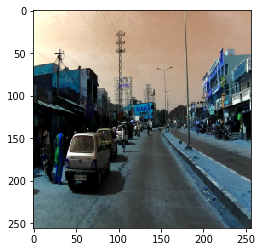

In [ ]:
# sample image
image = cv2.imread('data/images/201/frame0029_leftImg8bit.jpg', cv2.IMREAD_UNCHANGED) 
image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
plt.imshow(image, interpolation='nearest')
plt.show()

Getting Labels:

In [ ]:
import os
os.chdir('/content/drive/MyDrive/segmentation_data') # changing current working directory

In [ ]:
import json
def return_unique_labels(data_df):
  labels = []
  for i in data_df.json.values:
    f = open(i)
    data = json.load(f)
    f.close()
    for j in data['objects']:
      labels.append(j['label'])

  unique_labels = np.unique(np.array(labels))
  return unique_labels, labels

In [ ]:
unique_labels, labels = return_unique_labels(data_df)
unique_labels

array(['animal', 'autorickshaw', 'bicycle', 'billboard', 'bridge',
       'building', 'bus', 'car', 'caravan', 'curb', 'drivable fallback',
       'ego vehicle', 'fallback background', 'fence', 'ground',
       'guard rail', 'motorcycle', 'non-drivable fallback',
       'obs-str-bar-fallback', 'out of roi', 'parking', 'person', 'pole',
       'polegroup', 'rail track', 'rectification border', 'rider', 'road',
       'sidewalk', 'sky', 'traffic light', 'traffic sign', 'trailer',
       'train', 'truck', 'tunnel', 'unlabeled', 'vegetation',
       'vehicle fallback', 'wall'], dtype='<U21')

Merging labels and assigning values in range of image pixels(0-255)

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

Getting mask vertex dimensions:

In [ ]:
def get_poly(file):
    
    label = []
    vertexlist = []
    f = open(file)
    data = json.load(f)
    f.close()
    w = data['imgWidth']
    h = data['imgHeight']
    for i in data['objects']:
      label.append(i['label'])
      vertex = [tuple(x) for x in i['polygon']]  #https://blog.finxter.com/how-to-convert-list-of-lists-to-list-of-tuples-in-python/#:~:text=If%20you're%20in%20a,with%20varying%20number%20of%20elements.
      vertexlist.append(vertex)
      
    return w, h, label, vertexlist

In [ ]:
def compute_masks(data_df):

    mypath = 'data/output'
    if not os.path.isdir(mypath):
        os.makedirs(mypath)
        
    mask_paths = []
    for file in data_df.json.values:
      w, h, label, vertexlist = get_poly(file)
      img = Image.new("RGB", (w, h))
      img1 = ImageDraw.Draw(img)
      for i in range(len(label)):
        if len(vertexlist[i]) > 1:
         img1.polygon(vertexlist[i], fill = label_clr[label[i]])
        else:
          print(file)
          print(len(mask_paths))
       
      img=np.array(img)
      im = Image.fromarray(img[:,:,0])
      val=file[10:13]
      mypath = f'data/output/{val}'
      if not os.path.isdir(mypath):
        os.makedirs(mypath)
      val=file[10:-4]
      path = f'data/output/{val}png'
      im.save(path)
      mask_paths.append(path)
    data_df['mask']= mask_paths  
    return data_df

In [ ]:
data_df.to_csv('/content/drive/MyDrive/segmentation_data/preprocessed_edit_data_segmentation.csv', index=False)

In [ ]:
len(data_df)

4001

In [ ]:
data_df = pd.read_csv('/content/drive/MyDrive/segmentation_data/preprocessed_edit_data_segmentation.csv')
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


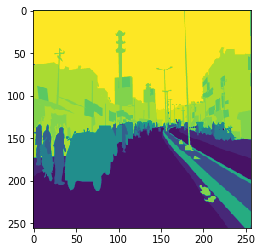

In [ ]:
# sample mask image
mask = cv2.imread('data/output/201/frame0029_gtFine_polygons.png', cv2.IMREAD_UNCHANGED) 
mask = cv2.resize(mask,(256,256),interpolation=cv2.INTER_AREA)
plt.imshow(mask, interpolation='nearest')
plt.show()

Dataset Generator:

In [ ]:
!pip install imagecorruptions

In [ ]:
import imgaug.augmenters as iaa
aug_crop = iaa.Crop(percent=0.3, seed=66, keep_size=True) #crop
aug_flip = iaa.Fliplr(1) #flip

In [ ]:
image_size=(256,256,3) # resizing image

In [ ]:
class Dataset:
  
  def __init__(self, images_dir, mask_dir, classes,training=True):

    self.images_fps = images_dir
    self.masks_fps = mask_dir
    self.classes = classes
    self.training = training

  def __getitem__(self, i):
    os.chdir('/content/drive/MyDrive/segmentation_data')
    image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) # reading image
    mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED) # reading mask
    image = cv2.resize(image,image_size[:2],interpolation=cv2.INTER_AREA) # resize image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    mask = cv2.resize(mask,image_size[:2],interpolation=cv2.INTER_AREA) # resize mask

    if self.training == True: # while training, augmenting images/mask
      a = np.random.uniform() # 40% images will be augmented, 10% chances of each augmentation method
      if a<0.10: # flip
          image = aug_flip.augment_image(image)
          mask = aug_flip.augment_image(mask)
          
      elif a<0.20: # crop
          image = aug_crop.augment_image(image)
          mask = aug_crop.augment_image(mask)

      elif a<0.30: # flip and crop
          image = aug_flip.augment_image(image)
          image = aug_crop.augment_image(image)
          mask = aug_flip.augment_image(mask)
          mask = aug_crop.augment_image(mask)

      elif a<0.40: # change brightness
          image = tf.image.adjust_brightness(image, 0.2)

    image_mask = [(mask == v) for v in self.classes] # making mask image dim. equal to no. of classes, each dim. having pixel value of each class
    image_mask = np.stack(image_mask, axis=-1).astype('float') # [256,256,21] if image_size=256,256

    return image, image_mask
        
  def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) # shuffling

In [ ]:
from sklearn.model_selection import train_test_split
X_trainval, X_test = train_test_split(data_df[['image','mask']], test_size=0.10, random_state=42)
X_train, X_val = train_test_split(X_trainval[['image','mask']], test_size=0.12, random_state=42)

Model:

In [ ]:
! pip install segmentation-models

In [ ]:
import tensorflow as tf
import segmentation_models as sm
from segmentation_models import Unet

sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
# https://segmentation-models.readthedocs.io/en/latest/api.html#unet

model = Unet(
    backbone_name='resnet34', # resnet34 as encoder of unet
    encoder_weights='imagenet', # initializing with pretrained imagenet weights
    classes=21, activation='softmax', 
    input_shape=image_size, 
    encoder_freeze=False, # encoder block is trainable
    decoder_block_type='upsampling' # using upsampling instead of Transpose2D
    )

85521592/85521592 [==============================] - 1s 0us/step


In [ ]:
from segmentation_models.metrics import iou_score

optimizer = tf.keras.optimizers.Adam()

total_loss = sm.losses.cce_dice_loss # cce_dice_loss = categorical_crossentropy + dice_loss
# https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/losses.py

metric = iou_score # https://segmentation-models.readthedocs.io/en/latest/api.html#metrics

Dataset Loader:

In [ ]:
classes = np.arange(0,210,10)
train_dataset = Dataset(X_train.values[:,0], X_train.values[:,1], classes=classes, training=True)
val_dataset  = Dataset(X_val.values[:,0], X_val.values[:,1], classes=classes,  training=False)
test_dataset  = Dataset(X_test.values[:,0], X_test.values[:,1], classes=classes,  training=False)

batch_size=32
train_dataloader = Dataloder(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(32, 256, 256, 3)
(32, 256, 256, 21)


Callback:

In [ ]:
from itertools import combinations
import os
import datetime

log_dir = os.path.join('/content/drive/MyDrive/segmentation_data/model_data',"logs",'modelunet','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

modelsave_wt = tf.keras.callbacks.ModelCheckpoint(
                     filepath='/content/drive/MyDrive/segmentation_data/model_data/model_wt/model.{epoch:02d}-{val_iou_score:.4f}.h5', 
                     save_freq='epoch', verbose=1, monitor='val_iou_score', 
                     save_weights_only=True, save_best_only=False
                 ) 

In [ ]:
%load_ext tensorboard
!rm -rf ./content/drive/MyDrive/segmentation_data/model_data/logs/

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/segmentation_data/model_data/logs/modelunet/fits

Training:

In [ ]:
model.compile(optimizer, 
              total_loss, 
              metrics=[metric])

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=5,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt, tensorboard_callback])

Epoch 1/5
99/99 [==============================] - ETA: 0s - loss: 0.8422 - iou_score: 0.1525 
Epoch 1: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.01-0.0811.h5
99/99 [==============================] - 4846s 49s/step - loss: 0.8422 - iou_score: 0.1525 - val_loss: 0.9660 - val_iou_score: 0.0811
Epoch 2/5
99/99 [==============================] - ETA: 0s - loss: 0.7196 - iou_score: 0.2401 
Epoch 2: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.02-0.0913.h5
99/99 [==============================] - 4502s 45s/step - loss: 0.7196 - iou_score: 0.2401 - val_loss: 1.0055 - val_iou_score: 0.0913
Epoch 3/5
99/99 [==============================] - ETA: 0s - loss: 0.6626 - iou_score: 0.2829 
Epoch 3: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.03-0.2144.h5
99/99 [==============================] - 4482s 45s/step - loss: 0.6626 - iou_score: 0.2829 - val_loss: 0.7677 - val_iou_score: 0.214

In [ ]:
model.load_weights('/content/drive/MyDrive/segmentation_data/model_data/model_wt/model.04-0.2936.h5')
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=6,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt, tensorboard_callback],initial_epoch=4)

Epoch 5/6
99/99 [==============================] - ETA: 0s - loss: 0.6128 - iou_score: 0.3218 
Epoch 5: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.05-0.3301.h5
99/99 [==============================] - 3213s 32s/step - loss: 0.6128 - iou_score: 0.3218 - val_loss: 0.6021 - val_iou_score: 0.3301
Epoch 6/6
99/99 [==============================] - ETA: 0s - loss: 0.5868 - iou_score: 0.3430
Epoch 6: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.06-0.3079.h5
99/99 [==============================] - 255s 3s/step - loss: 0.5868 - iou_score: 0.3430 - val_loss: 0.6267 - val_iou_score: 0.3079


In [ ]:
model.load_weights('/content/drive/MyDrive/segmentation_data/model_data/model_wt/model.06-0.3079.h5')
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt, tensorboard_callback],initial_epoch=6)

Epoch 7/10
99/99 [==============================] - ETA: 0s - loss: 0.5808 - iou_score: 0.3484
Epoch 7: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.07-0.3124.h5
99/99 [==============================] - 256s 3s/step - loss: 0.5808 - iou_score: 0.3484 - val_loss: 0.6203 - val_iou_score: 0.3124
Epoch 8/10
99/99 [==============================] - ETA: 0s - loss: 0.5634 - iou_score: 0.3636
Epoch 8: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.08-0.3527.h5
99/99 [==============================] - 252s 3s/step - loss: 0.5634 - iou_score: 0.3636 - val_loss: 0.5779 - val_iou_score: 0.3527
Epoch 9/10
99/99 [==============================] - ETA: 0s - loss: 0.5591 - iou_score: 0.3673
Epoch 9: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.09-0.3496.h5
99/99 [==============================] - 253s 3s/step - loss: 0.5591 - iou_score: 0.3673 - val_loss: 0.5823 - val_iou_score: 0.3496
Epoc

In [ ]:
model.load_weights('/content/drive/MyDrive/segmentation_data/model_data/model_wt/model.10-0.2896.h5')
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=15,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt, tensorboard_callback],initial_epoch=10)

Epoch 11/15
99/99 [==============================] - ETA: 0s - loss: 0.4526 - iou_score: 0.4733
Epoch 11: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.11-0.4536.h5
99/99 [==============================] - 254s 3s/step - loss: 0.4526 - iou_score: 0.4733 - val_loss: 0.4735 - val_iou_score: 0.4536
Epoch 12/15
99/99 [==============================] - ETA: 0s - loss: 0.4445 - iou_score: 0.4804
Epoch 12: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.12-0.4664.h5
99/99 [==============================] - 250s 3s/step - loss: 0.4445 - iou_score: 0.4804 - val_loss: 0.4629 - val_iou_score: 0.4664
Epoch 13/15
99/99 [==============================] - ETA: 0s - loss: 0.4070 - iou_score: 0.5179
Epoch 13: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.13-0.4993.h5
99/99 [==============================] - 251s 3s/step - loss: 0.4070 - iou_score: 0.5179 - val_loss: 0.4331 - val_iou_score: 0.499

In [ ]:
model.load_weights('/content/drive/MyDrive/segmentation_data/model_data/model_wt/model.15-0.4858.h5')
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=20,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=15)

Epoch 16/20
99/99 [==============================] - ETA: 0s - loss: 0.3837 - iou_score: 0.5400 
Epoch 16: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.16-0.5150.h5
99/99 [==============================] - 6527s 66s/step - loss: 0.3837 - iou_score: 0.5400 - val_loss: 0.4148 - val_iou_score: 0.5150
Epoch 17/20
99/99 [==============================] - ETA: 0s - loss: 0.3781 - iou_score: 0.5450
Epoch 17: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.17-0.5261.h5
99/99 [==============================] - 305s 3s/step - loss: 0.3781 - iou_score: 0.5450 - val_loss: 0.3997 - val_iou_score: 0.5261
Epoch 18/20
99/99 [==============================] - ETA: 0s - loss: 0.3740 - iou_score: 0.5484
Epoch 18: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.18-0.5295.h5
99/99 [==============================] - 295s 3s/step - loss: 0.3740 - iou_score: 0.5484 - val_loss: 0.3971 - val_iou_score: 0.

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=25,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=20)

Epoch 21/25
99/99 [==============================] - ETA: 0s - loss: 0.3687 - iou_score: 0.5547
Epoch 21: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.21-0.5279.h5
99/99 [==============================] - 311s 3s/step - loss: 0.3687 - iou_score: 0.5547 - val_loss: 0.4027 - val_iou_score: 0.5279
Epoch 22/25
99/99 [==============================] - ETA: 0s - loss: 0.3666 - iou_score: 0.5564
Epoch 22: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.22-0.5433.h5
99/99 [==============================] - 302s 3s/step - loss: 0.3666 - iou_score: 0.5564 - val_loss: 0.3843 - val_iou_score: 0.5433
Epoch 23/25
99/99 [==============================] - ETA: 0s - loss: 0.3565 - iou_score: 0.5666
Epoch 23: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.23-0.5543.h5
99/99 [==============================] - 320s 3s/step - loss: 0.3565 - iou_score: 0.5666 - val_loss: 0.3701 - val_iou_score: 0.554

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=30,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=25)

Epoch 26/30
99/99 [==============================] - ETA: 0s - loss: 0.3458 - iou_score: 0.5770
Epoch 26: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.26-0.3841.h5
99/99 [==============================] - 301s 3s/step - loss: 0.3458 - iou_score: 0.5770 - val_loss: 0.7084 - val_iou_score: 0.3841
Epoch 27/30
99/99 [==============================] - ETA: 0s - loss: 0.3468 - iou_score: 0.5764
Epoch 27: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.27-0.5544.h5
99/99 [==============================] - 299s 3s/step - loss: 0.3468 - iou_score: 0.5764 - val_loss: 0.3717 - val_iou_score: 0.5544
Epoch 28/30
99/99 [==============================] - ETA: 0s - loss: 0.3458 - iou_score: 0.5777
Epoch 28: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.28-0.5305.h5
99/99 [==============================] - 297s 3s/step - loss: 0.3458 - iou_score: 0.5777 - val_loss: 0.3997 - val_iou_score: 0.530

In [ ]:
model.load_weights('/content/drive/MyDrive/segmentation_data/model_data/model_wt/model.30-0.5516.h5')
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=35,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=30)

Epoch 31/35
99/99 [==============================] - ETA: 0s - loss: 0.3358 - iou_score: 0.5876 
Epoch 31: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.31-0.5478.h5
99/99 [==============================] - 6344s 63s/step - loss: 0.3358 - iou_score: 0.5876 - val_loss: 0.3809 - val_iou_score: 0.5478
Epoch 32/35
99/99 [==============================] - ETA: 0s - loss: 0.3308 - iou_score: 0.5920
Epoch 32: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.32-0.5464.h5
99/99 [==============================] - 298s 3s/step - loss: 0.3308 - iou_score: 0.5920 - val_loss: 0.3801 - val_iou_score: 0.5464
Epoch 33/35
99/99 [==============================] - ETA: 0s - loss: 0.3373 - iou_score: 0.5860
Epoch 33: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.33-0.5455.h5
99/99 [==============================] - 297s 3s/step - loss: 0.3373 - iou_score: 0.5860 - val_loss: 0.3802 - val_iou_score: 0.

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=40,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=35)

Epoch 36/40
99/99 [==============================] - ETA: 0s - loss: 0.3281 - iou_score: 0.5952
Epoch 36: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.36-0.5594.h5
99/99 [==============================] - 300s 3s/step - loss: 0.3281 - iou_score: 0.5952 - val_loss: 0.3665 - val_iou_score: 0.5594
Epoch 37/40
99/99 [==============================] - ETA: 0s - loss: 0.3281 - iou_score: 0.5951
Epoch 37: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.37-0.5404.h5
99/99 [==============================] - 300s 3s/step - loss: 0.3281 - iou_score: 0.5951 - val_loss: 0.3871 - val_iou_score: 0.5404
Epoch 38/40
99/99 [==============================] - ETA: 0s - loss: 0.3297 - iou_score: 0.5935
Epoch 38: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.38-0.5599.h5
99/99 [==============================] - 303s 3s/step - loss: 0.3297 - iou_score: 0.5935 - val_loss: 0.3662 - val_iou_score: 0.559

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=45,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=40)

Epoch 41/45
99/99 [==============================] - ETA: 0s - loss: 0.3248 - iou_score: 0.5988
Epoch 41: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.41-0.5319.h5
99/99 [==============================] - 308s 3s/step - loss: 0.3248 - iou_score: 0.5988 - val_loss: 0.3974 - val_iou_score: 0.5319
Epoch 42/45
99/99 [==============================] - ETA: 0s - loss: 0.3317 - iou_score: 0.5916
Epoch 42: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.42-0.5479.h5
99/99 [==============================] - 296s 3s/step - loss: 0.3317 - iou_score: 0.5916 - val_loss: 0.3819 - val_iou_score: 0.5479
Epoch 43/45
99/99 [==============================] - ETA: 0s - loss: 0.3206 - iou_score: 0.6031
Epoch 43: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.43-0.5661.h5
99/99 [==============================] - 293s 3s/step - loss: 0.3206 - iou_score: 0.6031 - val_loss: 0.3611 - val_iou_score: 0.566

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=50,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=45)

Epoch 46/50
99/99 [==============================] - ETA: 0s - loss: 0.3113 - iou_score: 0.6125
Epoch 46: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.46-0.5720.h5
99/99 [==============================] - 308s 3s/step - loss: 0.3113 - iou_score: 0.6125 - val_loss: 0.3553 - val_iou_score: 0.5720
Epoch 47/50
99/99 [==============================] - ETA: 0s - loss: 0.3038 - iou_score: 0.6208
Epoch 47: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.47-0.5704.h5
99/99 [==============================] - 304s 3s/step - loss: 0.3038 - iou_score: 0.6208 - val_loss: 0.3575 - val_iou_score: 0.5704
Epoch 48/50
99/99 [==============================] - ETA: 0s - loss: 0.3056 - iou_score: 0.6189
Epoch 48: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.48-0.5686.h5
99/99 [==============================] - 304s 3s/step - loss: 0.3056 - iou_score: 0.6189 - val_loss: 0.3579 - val_iou_score: 0.568

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=55,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=50)

Epoch 51/55
99/99 [==============================] - ETA: 0s - loss: 0.2970 - iou_score: 0.6283
Epoch 51: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.51-0.5802.h5
99/99 [==============================] - 312s 3s/step - loss: 0.2970 - iou_score: 0.6283 - val_loss: 0.3471 - val_iou_score: 0.5802
Epoch 52/55
99/99 [==============================] - ETA: 0s - loss: 0.2949 - iou_score: 0.6309
Epoch 52: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.52-0.5806.h5
99/99 [==============================] - 306s 3s/step - loss: 0.2949 - iou_score: 0.6309 - val_loss: 0.3463 - val_iou_score: 0.5806
Epoch 53/55
99/99 [==============================] - ETA: 0s - loss: 0.2947 - iou_score: 0.6307
Epoch 53: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.53-0.5633.h5
99/99 [==============================] - 285s 3s/step - loss: 0.2947 - iou_score: 0.6307 - val_loss: 0.3653 - val_iou_score: 0.563

In [ ]:
hist_unet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=60,\
                      validation_data=val_dataloader, validation_steps = len(val_dataloader), \
                      callbacks=[modelsave_wt],initial_epoch=55)

Epoch 56/60
99/99 [==============================] - ETA: 0s - loss: 0.3038 - iou_score: 0.6209
Epoch 56: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.56-0.5747.h5
99/99 [==============================] - 316s 3s/step - loss: 0.3038 - iou_score: 0.6209 - val_loss: 0.3519 - val_iou_score: 0.5747
Epoch 57/60
99/99 [==============================] - ETA: 0s - loss: 0.3088 - iou_score: 0.6159
Epoch 57: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.57-0.5723.h5
99/99 [==============================] - 308s 3s/step - loss: 0.3088 - iou_score: 0.6159 - val_loss: 0.3540 - val_iou_score: 0.5723
Epoch 58/60
99/99 [==============================] - ETA: 0s - loss: 0.2997 - iou_score: 0.6256
Epoch 58: saving model to /content/drive/MyDrive/segmentation_data/model_data/model_wt/model.58-0.5746.h5
99/99 [==============================] - 308s 3s/step - loss: 0.2997 - iou_score: 0.6256 - val_loss: 0.3523 - val_iou_score: 0.574

Evaluating on Unseen Test Images

In [ ]:
model.evaluate(test_dataloader)

12/12 [==============================] - 421s 38s/step - loss: 0.3592 - iou_score: 0.5713


[0.35923275351524353, 0.5712983012199402]

In [ ]:
model.load_weights('/content/drive/MyDrive/segmentation_data/model_data/model_wt/model.49-0.5835.h5')

Random Unseen Test Images

1/1 [==============================] - 0s 386ms/step


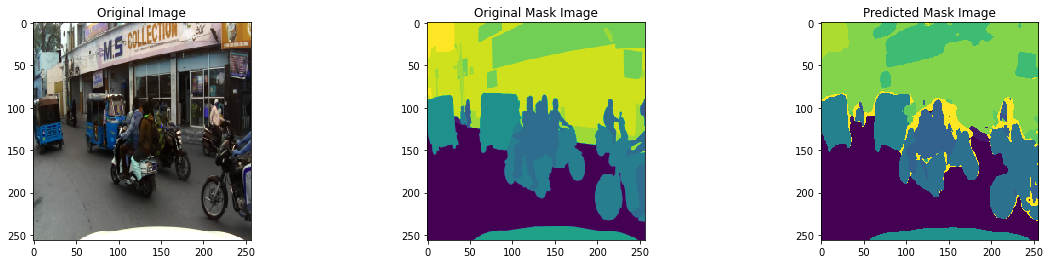

1/1 [==============================] - 0s 376ms/step


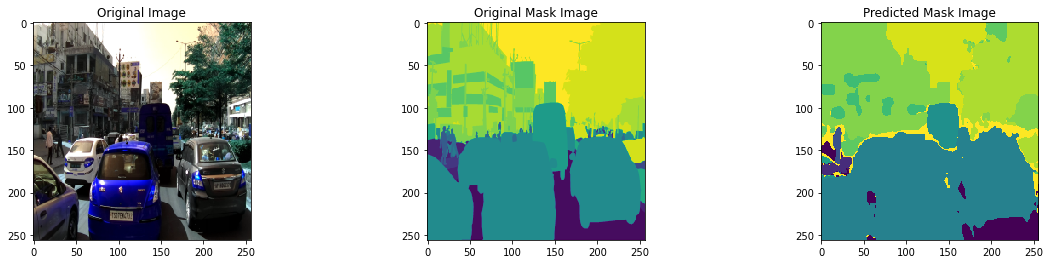

1/1 [==============================] - 0s 378ms/step


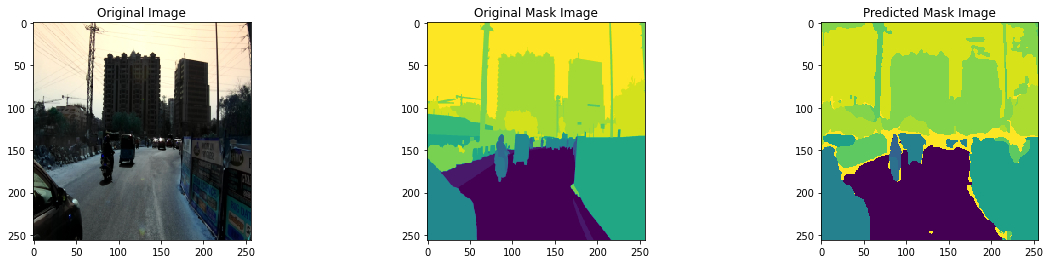

1/1 [==============================] - 1s 674ms/step


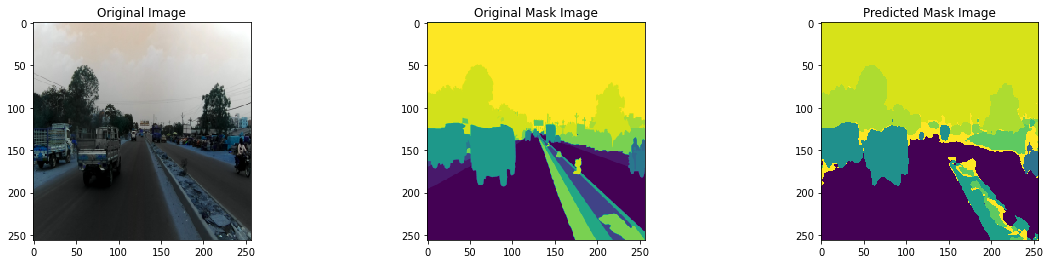

1/1 [==============================] - 1s 683ms/step


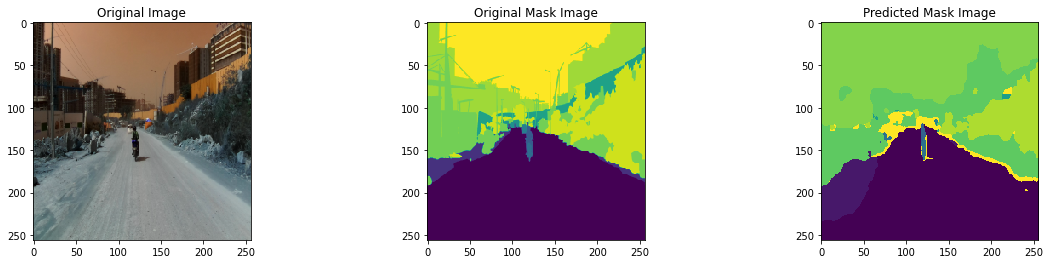

In [ ]:
for i in np.random.randint(0,len(X_test),5):
  
  image = cv2.imread(X_train.image.values[i], cv2.IMREAD_UNCHANGED) 
  image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
  mask = cv2.imread(X_train['mask'].values[i], cv2.IMREAD_UNCHANGED) 
  mask = cv2.resize(mask,(256,256),interpolation=cv2.INTER_AREA)

  plt.figure(figsize=(20,4))
  plt.subplot(1, 3,1)
  plt.title('Original Image')
  plt.imshow(image, interpolation='nearest')
  plt.subplot(1, 3,2)
  plt.title('Original Mask Image')
  plt.imshow(mask, interpolation='nearest')
  plt.subplot(1, 3,3)
  out=model.predict(tf.expand_dims(image,0))
  plt.title('Predicted Mask Image')
  pred=np.argmax(out,axis=-1)[0]
  plt.imshow(pred, interpolation='nearest')
  plt.show()

Video Segmentation

In [ ]:
import cv2

In [ ]:
!pip install imageio_ffmpeg

In [ ]:
import os 
import moviepy.video.io.ImageSequenceClip

In [ ]:
def video_segmenter(video_path, image_every_n_seconds,videoimage_save_path,resize_shape,segmentation_model,videosegmentedimage_save_path, video_save_path ):
  video_path = video_path
  video = cv2.VideoCapture(video_path)
  # Calculate how often to export frame to image
  frames_per_second = np.ceil(video.get(cv2.CAP_PROP_FPS)) #https://danielcorcoranssql.wordpress.com/2019/04/10/cv2-extracting-images-from-videos/
  image_every_n_seconds = image_every_n_seconds
  multiplier = frames_per_second * image_every_n_seconds

  currentFrame = 0
  while(True):
      ret, frame = video.read()
      # If frame doesnt exist, break
      if frame is None:
          break
      image_path = videoimage_save_path + str(currentFrame) + '.jpg' 
      if currentFrame % multiplier == 0:  # saving images from video as per given image_every_n_seconds
        cv2.imwrite(image_path, frame) # saving image
        image = cv2.imread(videoimage_save_path + str(currentFrame) + '.jpg', cv2.IMREAD_UNCHANGED) # reading image
        image = cv2.resize(image,resize_shape,interpolation=cv2.INTER_AREA) # risizing
        out=segmentation_model.predict(tf.expand_dims(image,0)) # getting predicted masked image
        pred=np.argmax(out,axis=-1)[0] # argmax over softmax to get class
        plt.imsave(videosegmentedimage_save_path + str(currentFrame) + '.png', pred) # saving masked image
      currentFrame += 1

  video.release()
  cv2.destroyAllWindows()
  
  # https://stackoverflow.com/a/62434934
  image_folder = videosegmentedimage_save_path 
  fps = 1/image_every_n_seconds # fps for masked video to be created

  image_files = [os.path.join(image_folder,img) for img in os.listdir(image_folder) if img.endswith(".png")] # list of masked images from folder
  clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps) # making video from images as per set fps
  clip.write_videofile(video_save_path) # saving video

In [ ]:
video_path = '/content/drive/MyDrive/inputvid.mp4'
image_every_n_seconds = 0.2 #using 5 images per sec.
videoimage_save_path = '/content/drive/MyDrive/segmentation_data/vidimg/'
resize_shape = (256,256)
segmentation_model = model
videosegmentedimage_save_path = '/content/drive/MyDrive/segmentation_data/vidout/'
video_save_path = '/content/drive/MyDrive/segvid.mp4'

video_segmenter(video_path, image_every_n_seconds,videoimage_save_path,resize_shape,\
                segmentation_model,videosegmentedimage_save_path, video_save_path)

1/1 [==============================] - 0s 376ms/step
[MoviePy] >>>> Building video /content/drive/MyDrive/segvid.mp4
[MoviePy] Writing video /content/drive/MyDrive/segvid.mp4


100%|██████████| 105/105 [00:01<00:00, 89.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/segvid.mp4 



segmented video link:
https://drive.google.com/file/d/1Ita9Pe53zS6KC6khZ4rmfw1GvLoq8g3N/view?usp=sharing